In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests

In [2]:
# Floyd-Warshall algorithm
def floyd_warshall(AdjMatrix):
    n = len(AdjMatrix)
    cost = np.copy(AdjMatrix)
    cost[cost == 0] = np.inf
    for k in range(n):
        for i in range(n):
            for j in range(n):
                cost[i, j] = min(cost[i, j], cost[i, k] + cost[k, j])
    return cost

In [3]:
# shortest path kernel

def shortest_path_kernel1(S1, S2, k_walk):
    # Obtener índices donde las entradas son finitas
    indices_S1 = np.transpose(np.triu_indices_from(S1))
    indices_S2 = np.transpose(np.triu_indices_from(S2))
    
    # Filtrar valores finitos
    indices_S1 = indices_S1[np.isfinite(S1[indices_S1[:, 0], indices_S1[:, 1]])]
    indices_S2 = indices_S2[np.isfinite(S2[indices_S2[:, 0], indices_S2[:, 1]])]

    # Convertir las entradas relevantes en arrays
    S1_finite = S1[indices_S1[:, 0], indices_S1[:, 1]]
    S2_finite = S2[indices_S2[:, 0], indices_S2[:, 1]]
    
    # Calcular el kernel con producto cartesiano
    K = np.sum([k_walk(d1, d2) for d1 in S1_finite for d2 in S2_finite])
    
    return K

def shortest_path_kernel2(S1, S2, k_walk):
    K = 0
    n = len(S1)
    m = len(S2)
    for i in range(n):
        for j in range(i, n):
            for ii in range(m):
                for jj in range(ii, m):
                    if np.isfinite(S1[i, j]) and np.isfinite(S2[ii, jj]):
                        K += k_walk(S1[i, j], S2[ii, jj])
    return K

def shortest_path_kernel(S1, S2, k_walk):
    try:
        return shortest_path_kernel1(S1, S2, k_walk)
    except Exception as e:
        print(f"Error: {e}, trying another approach")
        return shortest_path_kernel2(S1, S2, k_walk)

In [17]:
# kernel walk functions
def dirac_kernel(a, b):
    return 1 if a == b else 0
    
def gaussian_kernel(a,b, sigma = 1/10):
    return np.exp(-((a-b)**2)*sigma)

def inverse_multiquadratic_kernel(a,b):
    return 1/np.sqrt(1+(a-b)**2)

In [5]:
def count_trips_mibici(data_user, threshold = 5, complement = False):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    if not complement:
        viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    else:
        viajes_user = viajes_user[viajes_user['counts'] < threshold]
    if viajes_user.empty:
        return None
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    viajes_user = viajes_user.sort_values(by = 'prob', ascending = False).reset_index(drop=True)
    return viajes_user

def compute_matrix(counter_user, normalized = False, self_loops = False):
    if not self_loops:
        counter_user = counter_user[counter_user['Est_A'] != counter_user['Est_B']]
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    matrix = np.zeros((len(vertex), len(vertex)))
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        count = current_trip["counts"]
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]

        matrix[vertex.index(estA)][vertex.index(estB)] = count
        matrix[vertex.index(estB)][vertex.index(estA)] = count
    if normalized:
        D = np.sum(matrix, axis = 1)
        D = np.diag(D)
        D = np.linalg.inv(np.sqrt(D))
        matrix = D @ matrix @ D
    return matrix

In [6]:
# function to compute the gram matrix

def gram_matrix(data, k_function, normalized = False, save = False, directory = None):
    """This function computes the gram matrix of the data using the kernel function k_function
    Parameters:
    data: list of matrices
    k_function: kernel function which takes two matrices as input
    normalized: boolean, if True the gram matrix is normalized
    save: boolean, if True the gram matrix is saved in the current directory
    directory: string, directory where the gram matrix is saved
    Returns:
    gram: gram matrix of the data
    """
    n = len(data)
    gram = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            gram[i, j] = k_function(data[i], data[j])
            gram[j, i] = gram[i, j]
    if normalized:
        D = np.diag(np.diag(gram))
        D = np.linalg.inv(np.sqrt(D))
        gram = D @ gram @ D
    if save:
        if not os.path.exists(directory):
            os.makedirs(directory)
        np.save(directory + 'gram_matrix.npy', gram)
    return gram

In [7]:
#dir = '/home/user/Desktop/Datos/'
dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [8]:
data_2019 = pd.read_csv(f'{dir}mibici/2019.csv')

In [9]:
# generate data
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1, 4)]
data = []
for date in dates:
    print("Procesando fecha: ", date)
    current_data = data_2019[data_2019['Inicio_del_viaje'].str.startswith(date)]
    current_counter = count_trips_mibici(current_data)
    current_matrix = compute_matrix(current_counter, self_loops=True)
    current_s = floyd_warshall(current_matrix)
    data.append(current_s)

Procesando fecha:  2019-01-01
Procesando fecha:  2019-01-02
Procesando fecha:  2019-01-03


In [22]:
# compute gram matrix
kernel = lambda x, y: shortest_path_kernel(x, y, dirac_kernel)
gram = gram_matrix(data, kernel)
print(gram)

[[2.134000e+03 3.461800e+04 4.316500e+04]
 [3.461800e+04 2.293064e+06 2.805713e+06]
 [4.316500e+04 2.805713e+06 3.509210e+06]]


In [23]:
gram2 = gram_matrix(data, kernel, normalized = True)
print(gram2)

[[1.         0.49487633 0.49880392]
 [0.49487633 1.         0.98907785]
 [0.49880392 0.98907785 1.        ]]


In [10]:
def plot_heatmap(matrix, title, labels, with_values = False):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xticks(np.arange(matrix.shape[1]), labels, rotation=90)
    plt.yticks(np.arange(matrix.shape[0]), labels)
    plt.xticks(np.arange(matrix.shape[1]))
    plt.yticks(np.arange(matrix.shape[0]))
    if with_values:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white')
    plt.show()

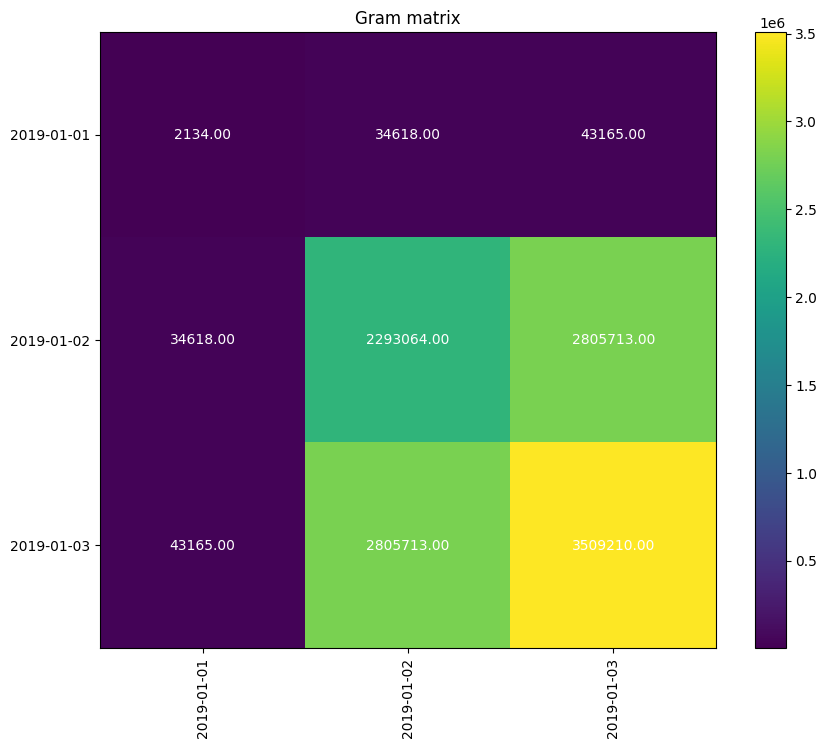

In [32]:
plot_heatmap(gram, title='Gram matrix', labels=dates)

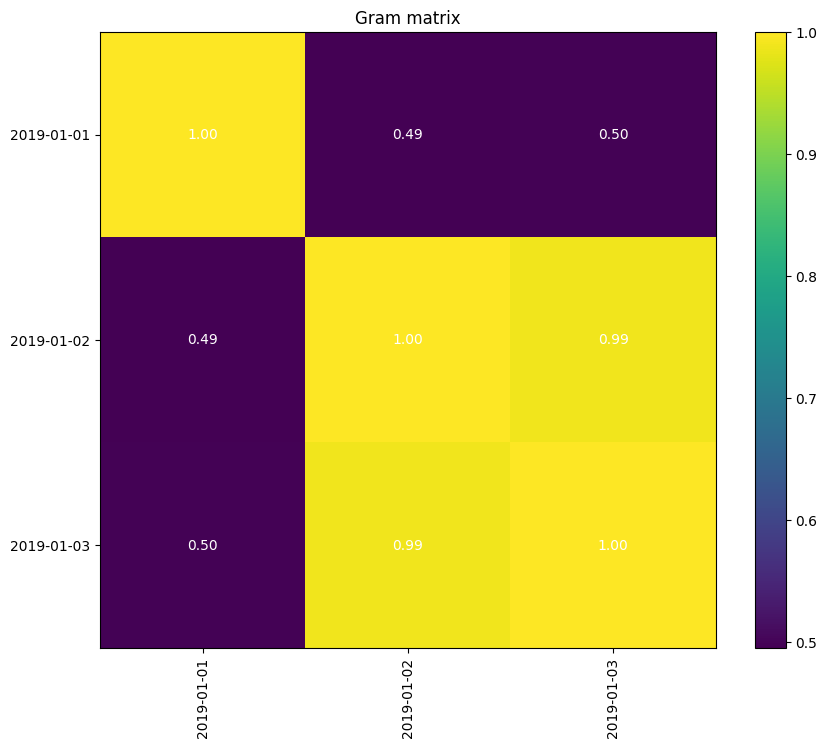

In [34]:
plot_heatmap(gram2, title='Gram matrix', labels=dates)

In [11]:
distances = [value for matrix in data for row in matrix for value in row if value != 0 and value != np.inf]

In [12]:
distances = np.unique(distances)
distances

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 63., 64., 66.])

In [13]:
d_pairs = [[i,j] for i in distances for j in distances]

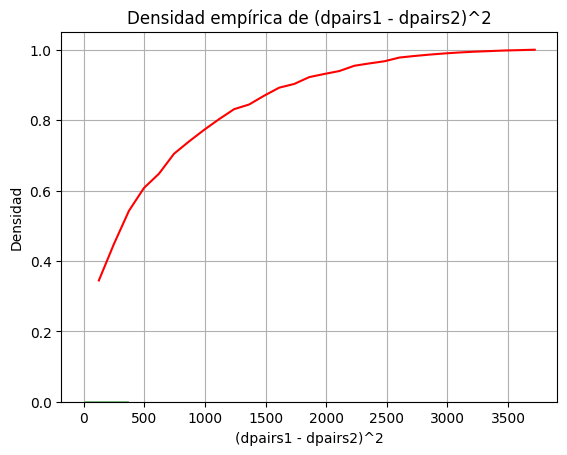

In [14]:
diff_squared = [(pair[0] - pair[1])**2 for pair in d_pairs]
density, bins, _ = plt.hist(diff_squared, bins=30, density=True, alpha=0.5, color='g')
count, _ = np.histogram(diff_squared, bins)
cdf = np.cumsum(count)
plt.plot(bins[1:], cdf / cdf[-1], 'r')
plt.title('Densidad empírica de (dpairs1 - dpairs2)^2')
plt.xlabel('(dpairs1 - dpairs2)^2')
plt.ylabel('Densidad')
plt.grid()
plt.show()

In [15]:
s = 1 / np.sqrt(np.max(diff_squared)/2)
s

0.023183828891362213

In [16]:
s1 = 1 / np.sqrt(np.median(diff_squared)/2)
s1

0.07856742013183861

In [23]:
s2 = 1 / np.sqrt(np.mean(diff_squared)/2)
s2

0.05736850809426752

Con $s_1$ (max)

In [ ]:
kernel = lambda x, y: shortest_path_kernel(x, y, lambda x, y: gaussian_kernel(x, y, sigma=s))

gram3 = gram_matrix(data, kernel)
print(gram3)

[[2.23059297e+04 1.09684569e+06 1.36839613e+06]
 [1.09684569e+06 5.52950332e+07 6.91184034e+07]
 [1.36839613e+06 6.91184034e+07 8.64263663e+07]]


In [56]:
gram4 = gram_matrix(data, kernel, normalized = True)
print(gram4)

[[1.         0.98762553 0.98554973]
 [0.98762553 1.         0.9998331 ]
 [0.98554973 0.9998331  1.        ]]


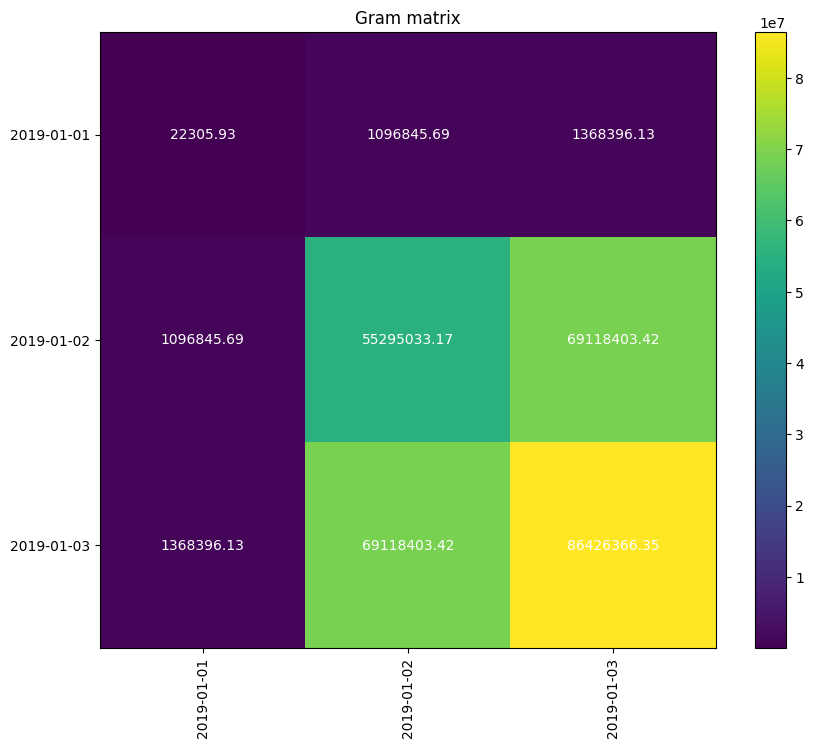

In [57]:
plot_heatmap(gram3, title='Gram matrix', labels=dates)

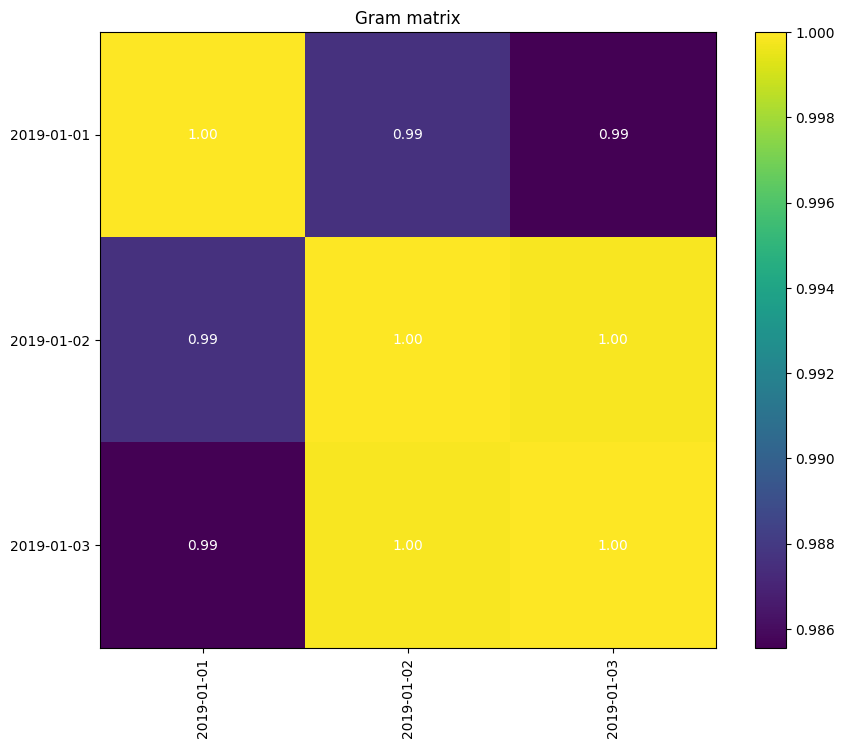

In [58]:
plot_heatmap(gram4, title='Gram matrix', labels=dates)

Con $s_2$ (mediana)

In [38]:
kernel = lambda x, y: shortest_path_kernel(x, y, lambda x, y: gaussian_kernel(x, y, sigma=s1))

gram3 = gram_matrix(data, kernel)
print(gram3)

[[1.72073405e+04 7.77942995e+05 9.57772196e+05]
 [7.77942995e+05 4.38193209e+07 5.33388900e+07]
 [9.57772196e+05 5.33388900e+07 6.51174460e+07]]


In [39]:
gram4 = gram_matrix(data, kernel, normalized = True)
print(gram4)

[[1.         0.89589699 0.90480849]
 [0.89589699 1.         0.99853312]
 [0.90480849 0.99853312 1.        ]]


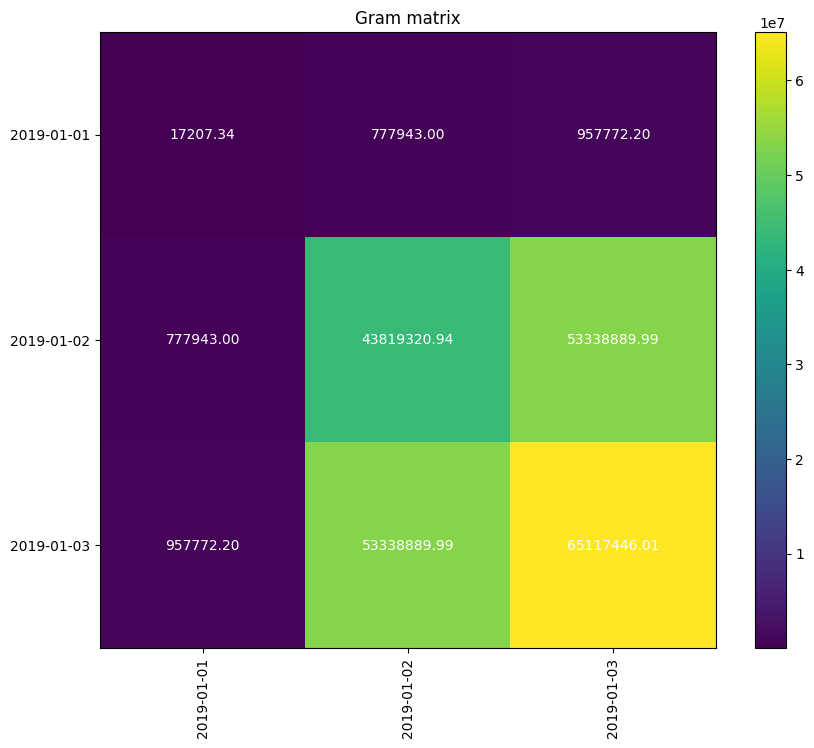

In [43]:
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1, 4)]
plot_heatmap(gram3, title='Gram matrix', labels=dates, with_values=True)

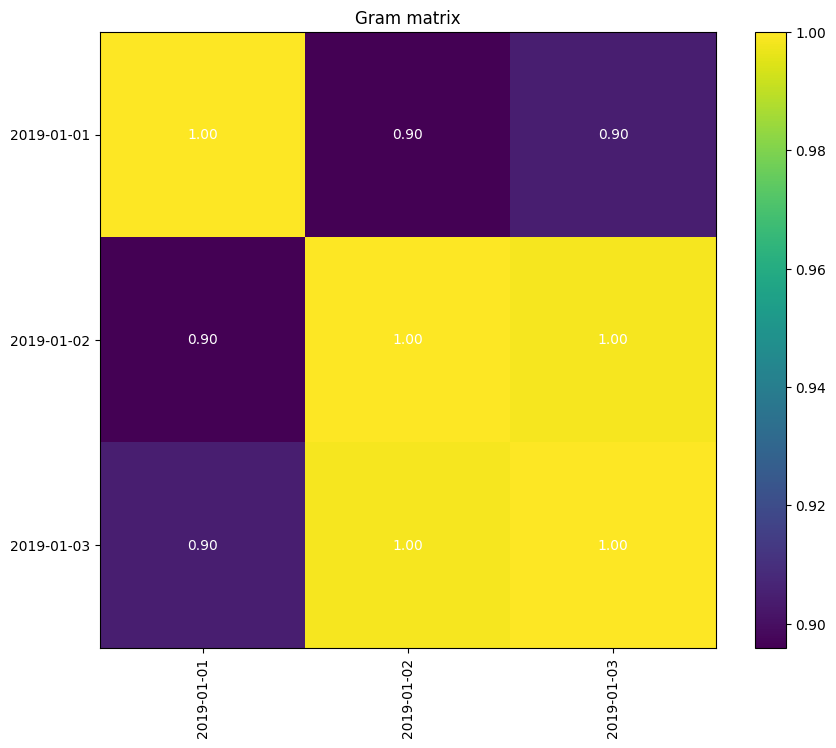

In [44]:
plot_heatmap(gram4, title='Gram matrix', labels=dates, with_values=True)

Con $s_3$ (media)

In [24]:
kernel = lambda x, y: shortest_path_kernel(x, y, lambda x, y: gaussian_kernel(x, y, sigma=s2))

gram3 = gram_matrix(data, kernel)
print(gram3)

[[6.86059269e+03 2.12748626e+05 2.65582488e+05]
 [2.12748626e+05 1.55720286e+07 1.89989532e+07]
 [2.65582488e+05 1.89989532e+07 2.34180278e+07]]


In [25]:
gram4 = gram_matrix(data, kernel, normalized=True)
print(gram4)

[[1.         0.65089862 0.66258783]
 [0.65089862 1.         0.9949057 ]
 [0.66258783 0.9949057  1.        ]]


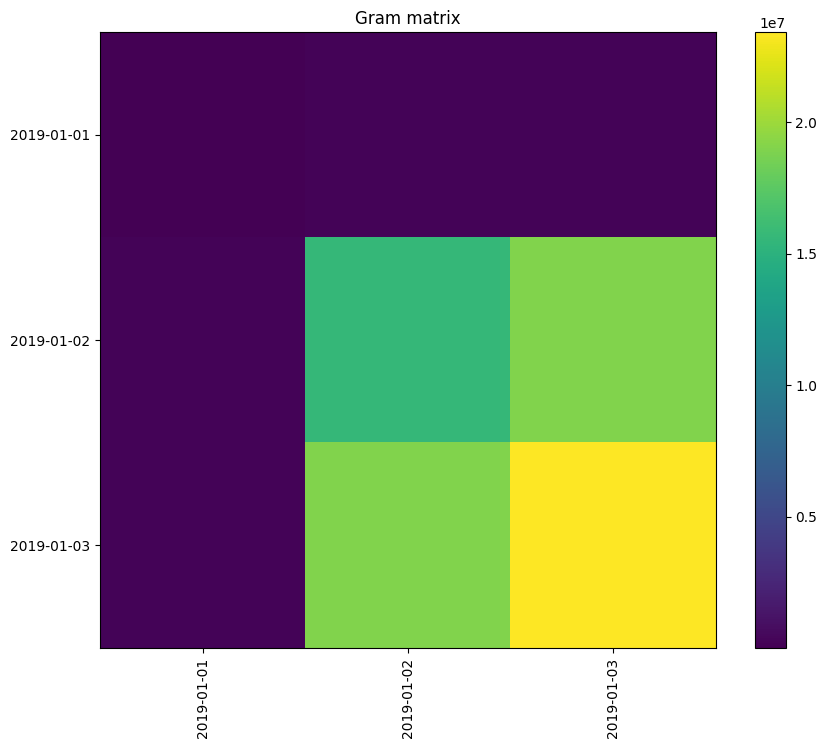

In [27]:
plot_heatmap(gram3, title='Gram matrix', labels=dates)

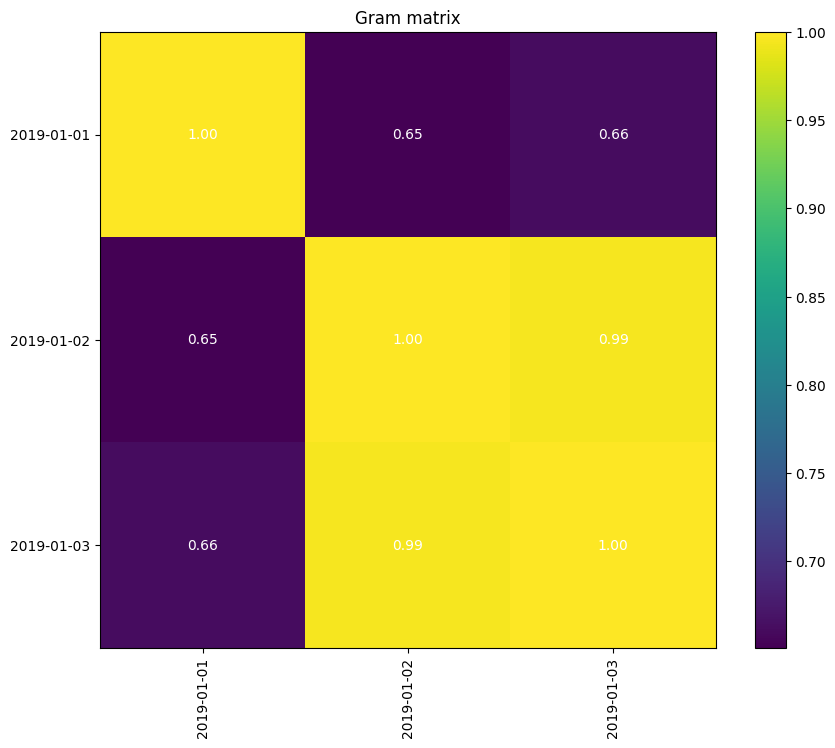

In [28]:
plot_heatmap(gram4, title='Gram matrix', labels=dates, with_values=True)

Con la multicuadrática invertida

In [18]:
kernel = lambda x, y: shortest_path_kernel(x, y, lambda x, y: inverse_multiquadratic_kernel(x, y))

gram5 = gram_matrix(data, kernel)
print(gram5)

[[6.18831452e+03 2.12492916e+05 2.64906284e+05]
 [2.12492916e+05 1.36024569e+07 1.66564124e+07]
 [2.64906284e+05 1.66564124e+07 2.05630823e+07]]


In [19]:
gram6 = gram_matrix(data, kernel, normalized = True)
print(gram6)

[[1.         0.73240211 0.742612  ]
 [0.73240211 1.         0.99592969]
 [0.742612   0.99592969 1.        ]]


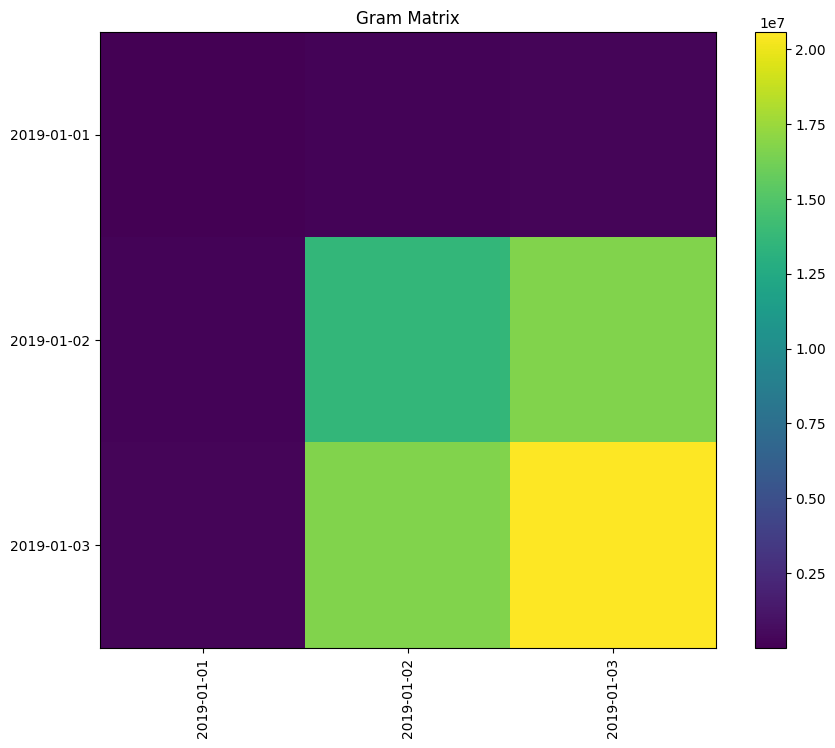

In [21]:
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1,4)]
plot_heatmap(gram5, "Gram Matrix", dates)

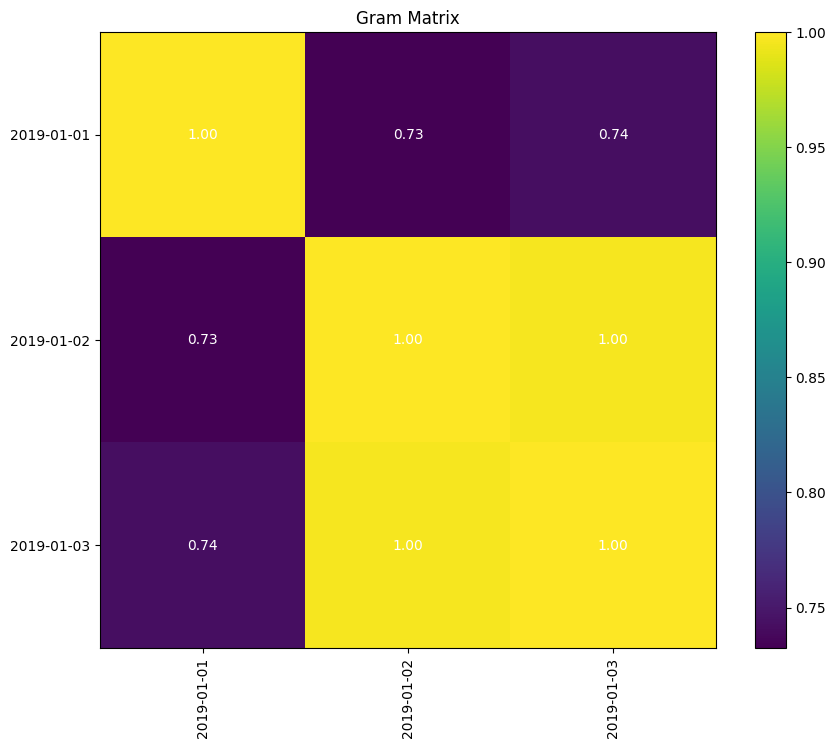

In [22]:
plot_heatmap(gram6, "Gram Matrix", dates, with_values=True)

In [26]:
requests.post("https://ntfy.sh/My_Computer", data="Proceso terminado".encode('utf-8'))

<Response [200]>

Resultados cluster

In [17]:
enero_1_15 = np.load("spk_matrix/1_dirac.npy")
enero_1_15_norm= np.load("spk_matrix/1_dirac_norm.npy")
enero_15_31 = np.load("spk_matrix/2_dirac.npy")
enero_15_31_norm = np.load("spk_matrix/2_dirac_norm.npy")
febrero_1_15_norm = np.load("spk_matrix/3_dirac.npy")
febrero_1_15 = np.load("spk_matrix/3_dirac_norm.npy")
febrero_15_28_norm = np.load("spk_matrix/4_dirac.npy")
febrero_15_28 = np.load("spk_matrix/4_dirac_norm.npy")

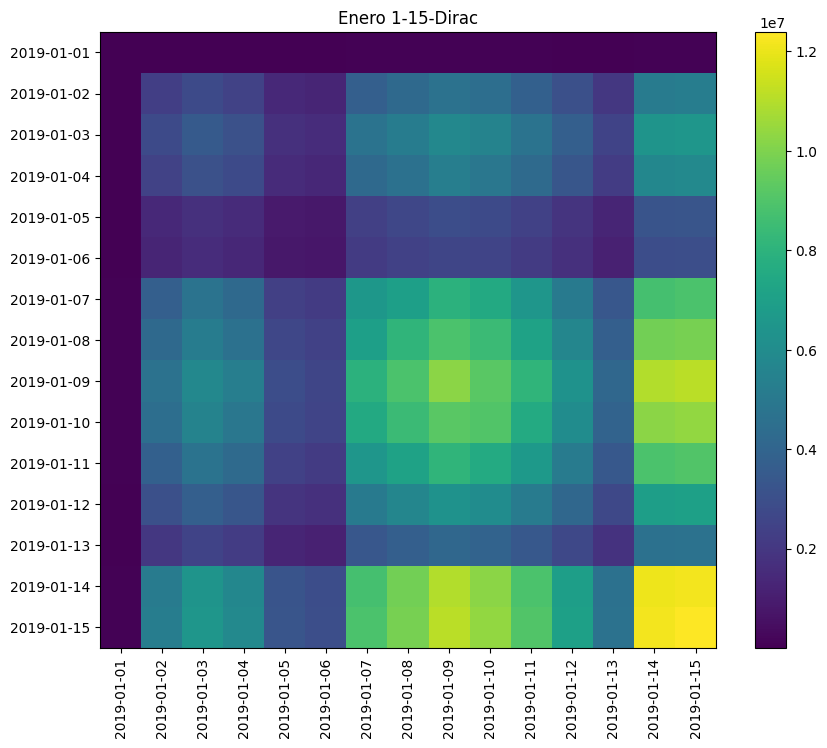

In [14]:
# first matrix
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1, 16)]
plot_heatmap(enero_1_15, title='Enero 1-15-Dirac', labels=dates)

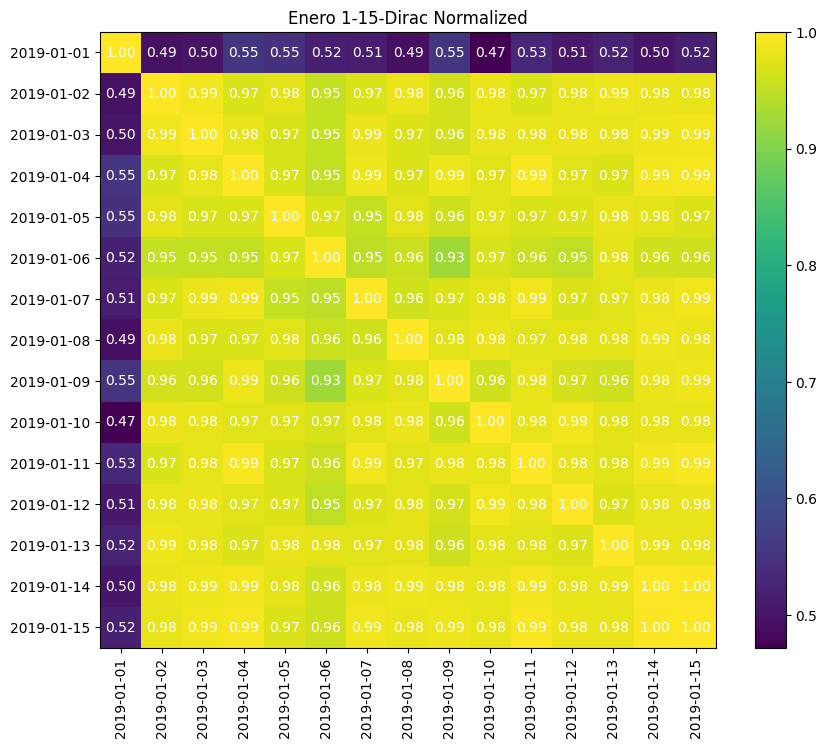

In [16]:
# second matrix
plot_heatmap(enero_1_15_norm, title='Enero 1-15-Dirac Normalized', labels=dates, with_values=True)

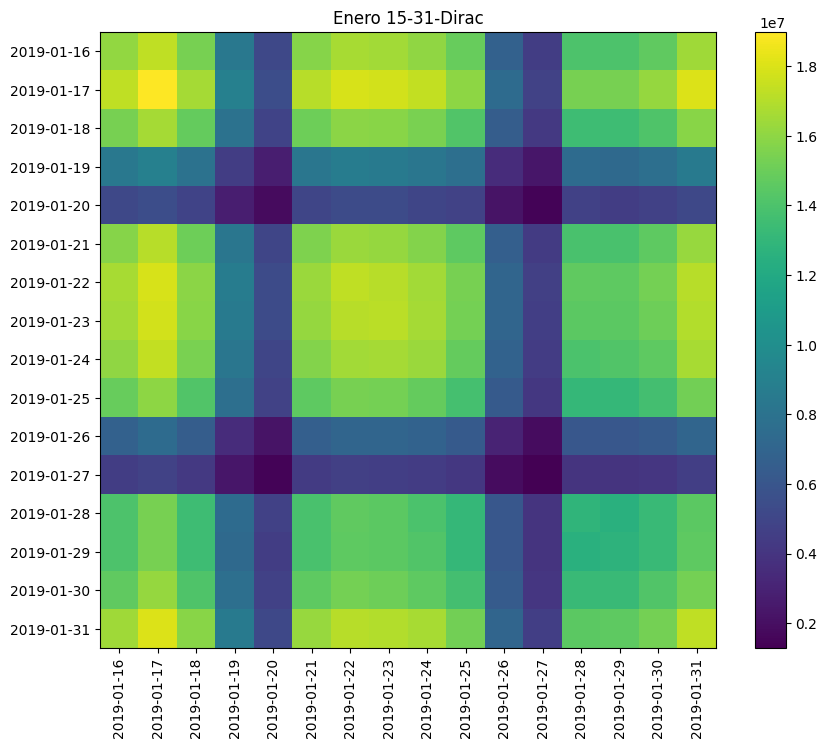

In [19]:
# third matrix
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(16, 32)]
plot_heatmap(enero_15_31, title='Enero 15-31-Dirac', labels=dates)

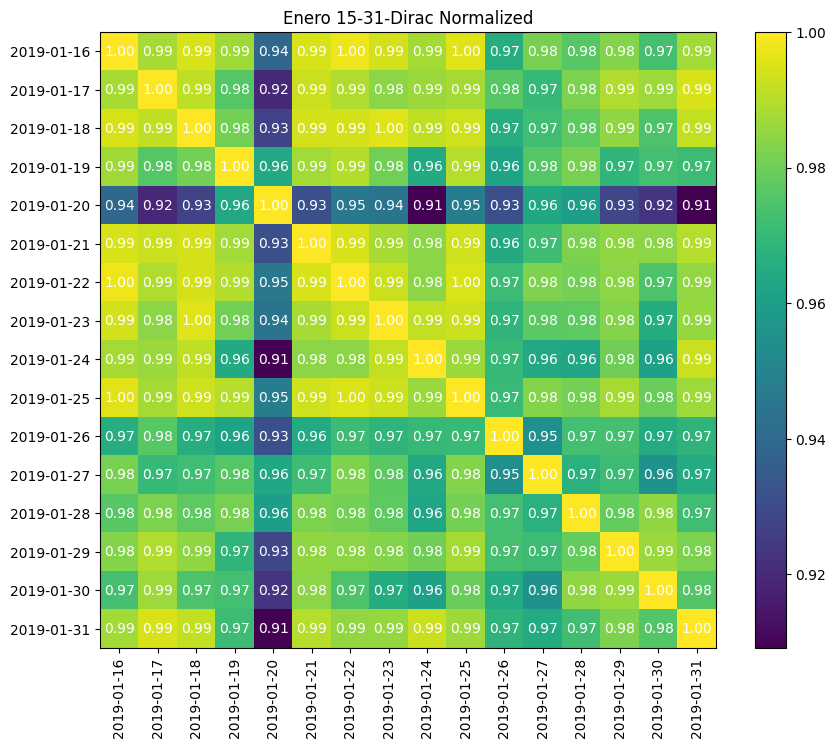

In [20]:
# fourth matrix
plot_heatmap(enero_15_31_norm, title='Enero 15-31-Dirac Normalized', labels=dates, with_values=True)

In [21]:
# with gaussian kernel
enero_15_31_gaussian = np.load("spk_matrix/1_exp.npy")
enero_15_31_gaussian_norm = np.load("spk_matrix/1_exp_norm.npy")

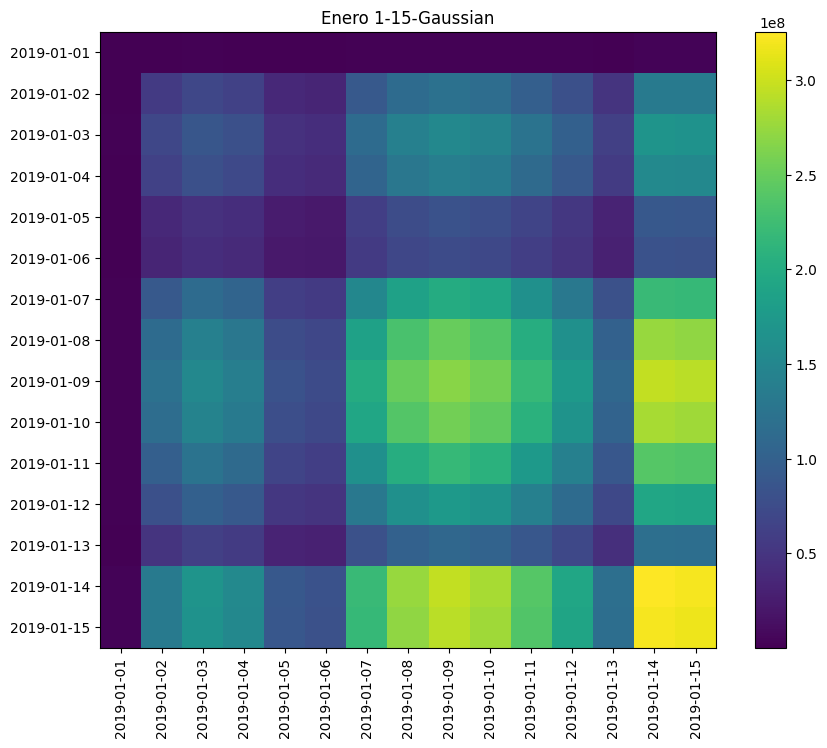

In [22]:
# first matrix
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1, 16)]
plot_heatmap(enero_15_31_gaussian, title='Enero 1-15-Gaussian', labels=dates)

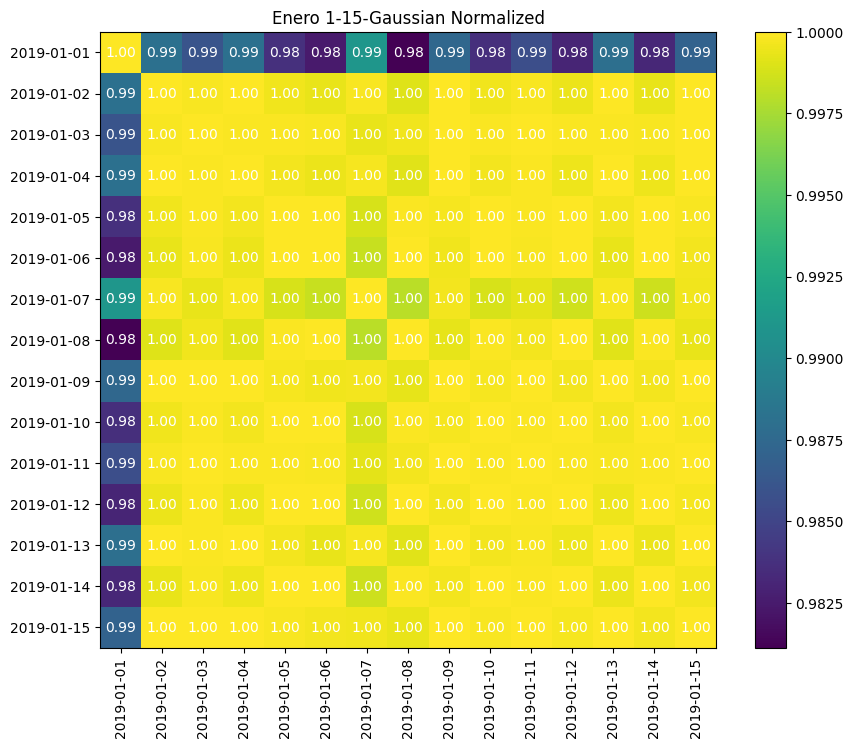

In [23]:
# second matrix
plot_heatmap(enero_15_31_gaussian_norm, title='Enero 1-15-Gaussian Normalized', labels=dates, with_values=True)